In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib
from afinn import Afinn

In [ ]:
df = pd.read_csv("/content/final (1).csv")
print(df.head())

feature_cols = ['teaching', 'coursecontent', 'examination', 'labwork']
target_col = 'target_label'


def heuristic_label(row):
    total_score = row['teaching'] + row['coursecontent'] + row['examination'] + row['labwork']
    if total_score < 0:
        return 'negative'
    elif total_score >= 2:
        return 'positive'
    else:
        return 'neutral'

df['target_label'] = df.apply(heuristic_label, axis=1)

   teaching  coursecontent  examination  labwork  \
0         0              0            1       -1   
1         1             -1            1        1   
2         1              1            1        1   
3         1             -1           -1        1   
4         1              1            1        1   

                                            comments  
0  teacher are punctual but they should also give...  
1                          Good ,Not good,Good,Good   
2  Excellent lectures are delivered by teachers a...  
3  Good,Content of course is perfectly in line wi...  
4  teachers give us all the information required ...  


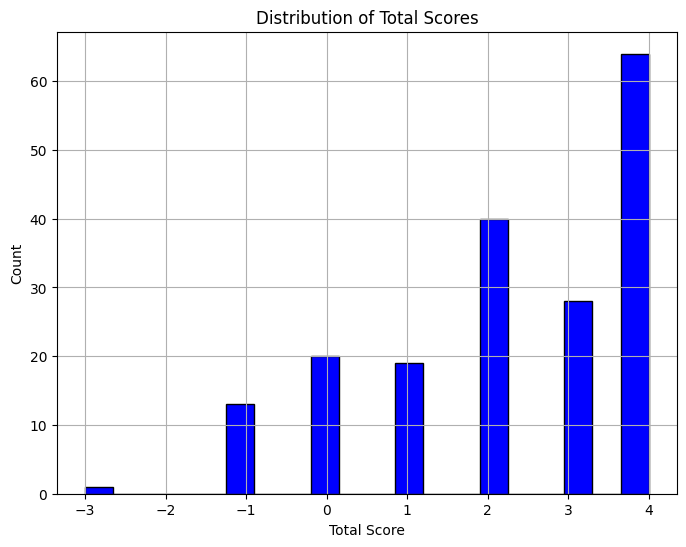

In [ ]:
import matplotlib.pyplot as plt

def heuristic_label1(row):
    total_score = row['teaching'] + row['coursecontent'] + row['examination'] + row['labwork']
    if total_score > 2:
        label = 'positive'
    elif total_score < 0:
        label = 'negative'
    else:
        label = 'neutral'

    return label, total_score

df[['Sentiment_Label', 'Total_Score']] = df.apply(heuristic_label1, axis=1, result_type='expand')

plt.figure(figsize=(8, 6))
plt.hist(df['Total_Score'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Total Score')
plt.ylabel('Count')
plt.title('Distribution of Total Scores')
plt.grid(True)
plt.show()

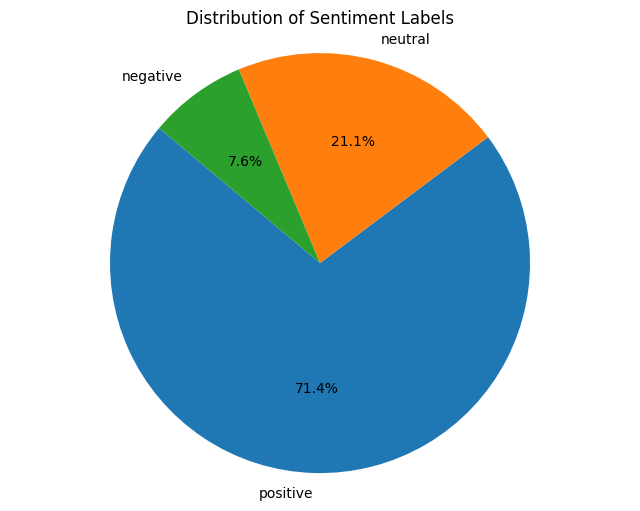

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def heuristic_label2(row):
    total_score = row[['teaching', 'coursecontent', 'examination', 'labwork']].sum()
    if total_score >= 2:
        label = 'positive'
    elif total_score < 0:
        label = 'negative'
    else:
        label = 'neutral'

    return label

df['Sentiment_Label'] = df.apply(heuristic_label2, axis=1)

sentiment_counts = df['Sentiment_Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Labels')
plt.axis('equal')
plt.show()

Classifier

In [ ]:
X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

df['Classifier_Prediction'] = svm_model.predict(df[feature_cols])

In [ ]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
     neutral       1.00      1.00      1.00         8
    positive       1.00      1.00      1.00        28

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [ ]:
example_row = df.sample(1)
example_features = example_row[['teaching', 'coursecontent', 'examination', 'labwork']].values
predicted_label = svm_model.predict(example_features)

print("Example features:")
print(example_row[['teaching', 'coursecontent', 'examination', 'labwork']])
print("Predicted label:", predicted_label[0])

Example features:
     teaching  coursecontent  examination  labwork
132         1             -1            0        1
Predicted label: neutral


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = SVC()

cv_scores = cross_val_score(clf, X, y, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.97297297 0.91891892 0.91891892 0.97297297 0.91891892]
Mean CV Score: 0.9405405405405407


In [ ]:
import pandas as pd

classifier_predictions_df = pd.DataFrame({'Classifier_Prediction': y_pred})
print(classifier_predictions_df.head())

  Classifier_Prediction
0               neutral
1              positive
2              positive
3              positive
4               neutral


In [ ]:
joblib.dump(svm_model, 'trained_classifier.pkl')

['trained_classifier.pkl']

Sentiment Analysis

In [ ]:
afinn = Afinn()

def assign_sentiment_label(comment):
    sentiment_score = afinn.score(comment)
    if sentiment_score > 2:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['comments'].apply(assign_sentiment_label)

In [ ]:
def assign_output_label(row):
    classifier_label = row['Classifier_Prediction']
    sentiment_label = row['sentiment_label']

    classifier_weight = 3 if classifier_label != 'neutral' else 1
    sentiment_weight = 1 if sentiment_label != 'neutral' else 0

    if classifier_weight > sentiment_weight:
        return classifier_label
    elif classifier_weight < sentiment_weight:
        return sentiment_label
    else:
        return classifier_label if classifier_label != 'neutral' else 'neutral'


df['Output_Label'] = df.apply(assign_output_label, axis=1)
print(df.head())

   teaching  coursecontent  examination  labwork  \
0         0              0            1       -1   
1         1             -1            1        1   
2         1              1            1        1   
3         1             -1           -1        1   
4         1              1            1        1   

                                            comments target_label  \
0  teacher are punctual but they should also give...      neutral   
1                          Good ,Not good,Good,Good      positive   
2  Excellent lectures are delivered by teachers a...     positive   
3  Good,Content of course is perfectly in line wi...      neutral   
4  teachers give us all the information required ...     positive   

  Classifier_Prediction sentiment_label Output_Label  
0               neutral        positive      neutral  
1              positive        positive     positive  
2              positive        positive     positive  
3               neutral        positive      neutral

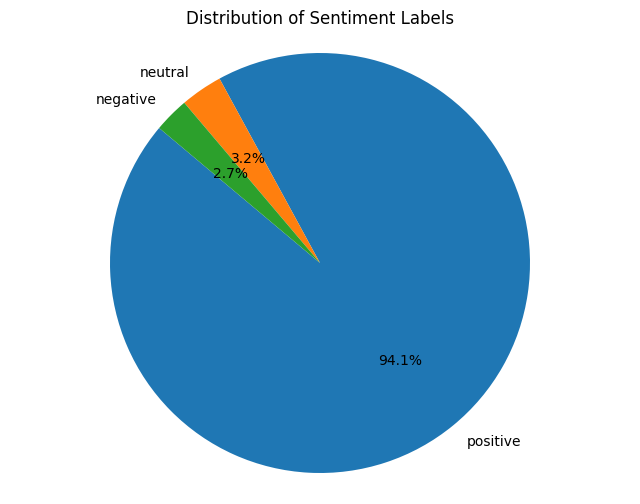

In [ ]:
import matplotlib.pyplot as plt
label_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Labels')
plt.axis('equal')
plt.show()

Combining the Classifier and Sentimental Analysis model

In [ ]:
class SentimentModel:
    def __init__(self, classifier_model_path):
        self.clf = joblib.load(classifier_model_path)
        self.afinn = Afinn()

    def preprocess(self, teaching, coursecontent, examination, labwork, comments):
        data = pd.DataFrame({
            'teaching': [teaching],
            'coursecontent': [coursecontent],
            'examination': [examination],
            'labwork': [labwork],
            'comments': [comments]
        })
        return data

    def predict_sentiment(self, comments):
        sentiment_score = self.afinn.score(comments)
        if sentiment_score > 2:
            return 'positive'
        elif sentiment_score < 0:
            return 'negative'
        else:
            return 'neutral'

    def predict(self, teaching, coursecontent, examination, labwork, comments):
        data = self.preprocess(teaching, coursecontent, examination, labwork, comments)
        classifier_prediction = self.clf.predict(data[['teaching', 'coursecontent', 'examination', 'labwork']])[0]
        sentiment_label = self.predict_sentiment(comments)
        combined_prediction = self.assign_output_label(classifier_prediction, sentiment_label)

        return classifier_prediction, sentiment_label, combined_prediction

    def assign_output_label(self, classifier_label, sentiment_label):
        classifier_weight = 3 if classifier_label != 'neutral' else 1
        sentiment_weight = 1 if sentiment_label != 'neutral' else 0

        if classifier_weight > sentiment_weight:
            return classifier_label
        elif classifier_weight < sentiment_weight:
            return sentiment_label
        else:
            return classifier_label if classifier_label != 'neutral' else 'neutral'

classifier_model_path = 'trained_classifier.pkl'
model = SentimentModel(classifier_model_path)

In [ ]:
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [ ]:
teaching = 0
coursecontent = 0
examination = 0
labwork = -1
comments = "I am not satisfied with the lab activities."

classifier_prediction, sentiment_label, final_output_label = model.predict(teaching, coursecontent, examination, labwork, comments)

print("Classifier Prediction:", classifier_prediction)
print("Sentiment Label:", sentiment_label)
print("Final Output Label:", final_output_label)

Classifier Prediction: negative
Sentiment Label: neutral
Final Output Label: negative


In [ ]:
teaching = 1
coursecontent = 1
examination = 1
labwork = 1
comments = "The course was quite informative and well structured."

classifier_prediction, sentiment_label, final_output_label = model.predict(teaching, coursecontent, examination, labwork, comments)

print("Classifier Prediction:", classifier_prediction)
print("Sentiment Label:", sentiment_label)
print("Final Output Label:", final_output_label)

Classifier Prediction: positive
Sentiment Label: neutral
Final Output Label: positive


In [ ]:
teaching = 0
coursecontent = 0
examination = 1
labwork = -1
comments = "Can procure more resources and teach better."

classifier_prediction, sentiment_label, final_output_label = model.predict(teaching, coursecontent, examination, labwork, comments)

print("Classifier Prediction:", classifier_prediction)
print("Sentiment Label:", sentiment_label)
print("Final Output Label:", final_output_label)

Classifier Prediction: neutral
Sentiment Label: neutral
Final Output Label: neutral


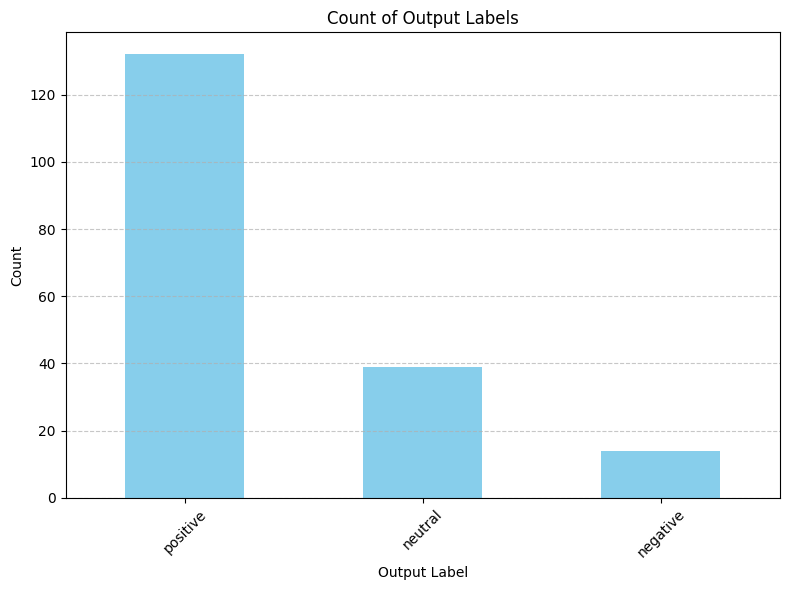

In [ ]:
df['Combined_Prediction'] = df.apply(assign_output_label, axis=1)
label_counts = df['Combined_Prediction'].value_counts()


plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Output Label')
plt.ylabel('Count')
plt.title('Count of Output Labels')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Frequency Count

In [ ]:
import pandas as pd
import joblib
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class WordFrequencyModel:
    def __init__(self):
        pass

    def preprocess_comments(self, comments):
        tokens = word_tokenize(comments)
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if word not in string.punctuation]
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

        return tokens

    def train(self, df):
        all_comments = ' '.join(df['comments'])
        tokens = self.preprocess_comments(all_comments)
        word_freq = Counter(tokens)
        sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

        return sorted_word_freq

In [ ]:
model1 = WordFrequencyModel()
sorted_word_freq = model1.train(df)
print("Top 10 most common words:")
for word, freq in sorted_word_freq[:10]:
    print(f"{word}: {freq}")

Top 10 most common words:
good: 461
course: 42
pattern: 40
lab: 39
excellent: 39
university: 39
students: 35
also: 34
knowledge: 34
teachers: 34


In [ ]:
import joblib


joblib.dump(model1, 'word_frequency_model.pkl')
print("Model saved successfully.")

Model saved successfully.
